# **Final Project Pembelajaran Mesin (KOMA): <br> Prediksi Ketimpangan Gender dalam Partisipasi Pendidikan di Indonesia menggunakan Model Regresi**
Anggota: 
- Andreas Notokusumo (22/493183/PA/21167)
- Aisyah Putri Khurin’in (22/493908/PA/21227)
- Irfan Fadilah Rafif (22/497042/PA/21389)
- Yessica Thipandona (22/497660/PA/21441)

Dosen Pengampu: Yunita Sari, S.Kom., M.Sc., Ph.D.

***Abstract*** <br>
Penelitian ini bertujuan untuk memprediksi ketimpangan gender dalam partisipasi pendidikan di Indonesia dengan menggunakan model regresi machine learning. Dengan menganalisis berbagai faktor yang berkontribusi terhadap ketimpangan gender dalam pendidikan, studi ini berupaya memberikan prediksi yang akurat yang dapat digunakan oleh pembuat kebijakan dan pemangku kepentingan. Model dievaluasi menggunakan metrik Mean Squared Error (MSE) dan R-squared (R²) untuk memastikan akurasi dan keandalannya. Hasil penelitian ini mengungkapkan wawasan penting mengenai pola dan tren ketimpangan gender dalam pendidikan, memungkinkan intervensi yang lebih efektif untuk mempromosikan akses pendidikan yang setara bagi semua gender.

## **1. Inisialisasi**

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

## **2. Data Preprocessing**

### Normalisasi Dataset (Cleaning dan Transpose Dataset)

In [14]:
file_path = 'Gender IDN.csv'
dataset = pd.read_csv(file_path)

# Hapus baris pertama yang berisi header kolom yang diulang
dataset = dataset.drop(0).reset_index(drop=True)

# Atur nama kolom yang benar
dataset.columns = ['Country Name', 'Country ISO3', 'Year', 'Indicator Name', 'Indicator Code', 'Value']

# Konversi kolom 'Year' dan 'Value' ke tipe data yang sesuai
dataset['Year'] = pd.to_numeric(dataset['Year'], errors='coerce')  # Konversi ke numeric, dengan errors='coerce' akan mengubah parsing yang tidak valid menjadi NaN
dataset = dataset.dropna(subset=['Year'])  # Hapus baris di mana 'Year' tidak bisa dikonversi
dataset['Year'] = dataset['Year'].astype(int)  # Konversi 'Year' ke integer
dataset['Value'] = pd.to_numeric(dataset['Value'], errors='coerce')  # Konversi 'Value' ke numeric

# Pivot dataset untuk memiliki tahun sebagai baris dan indikator sebagai kolom
normalized_dataset = dataset.pivot_table(index=['Year'], 
                                         columns='Indicator Name', 
                                         values='Value').reset_index()

# Ekspor dataset yang dinormalisasi ke file CSV baru
output_file_path = 'Normalized_Gender_IDN.csv'
normalized_dataset.to_csv(output_file_path, index=False)
print("Dataset yang dinormalisasi telah diekspor ke file: ", output_file_path)

print(normalized_dataset.columns)

Dataset yang dinormalisasi telah diekspor ke file:  Normalized_Gender_IDN.csv
Index(['Year',
       'A woman can apply for a passport in the same way as a man (1=yes; 0=no)',
       'A woman can be "head of household" in the same way as a man (1=yes; 0=no)',
       'A woman can choose where to live in the same way as a man (1=yes; 0=no)',
       'A woman can get a job in the same way as a man (1=yes; 0=no)',
       'A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no)',
       'A woman can open a bank account in the same way as a man (1=yes; 0=no)',
       'A woman can register a business in the same way as a man (1=yes; 0=no)',
       'A woman can sign a contract in the same way as a man (1=yes; 0=no)',
       'A woman can travel outside her home in the same way as a man (1=yes; 0=no)',
       ...
       'Women who believe a husband is justified in beating his wife when she refuses sex with him (%)',
       'Women who believe a wife is justified refusing sex

### *Feature Selection* and Handle Missing Values

In [15]:
file_path = "Normalized_Gender_IDN.csv"
normalized_dataset = pd.read_csv(file_path)

# Definisikan indikator
indicators = {
    "Adjusted net enrollment rate, primary": [
        "Adjusted net enrollment rate, primary, female (% of primary school age children)",
        "Adjusted net enrollment rate, primary, male (% of primary school age children)",
    ],
    "School enrollment, preprimary": [
        "School enrollment, preprimary, female (% gross)",
        "School enrollment, preprimary, male (% gross)",
    ],
    "School enrollment, primary (gross)": [
        "School enrollment, primary, female (% gross)",
        "School enrollment, primary, male (% gross)",
    ],
    "School enrollment, primary (net)": [
        "School enrollment, primary, female (% net)",
        "School enrollment, primary, male (% net)",
    ],
    "School enrollment, secondary (gross)": [
        "School enrollment, secondary, female (% gross)",
        "School enrollment, secondary, male (% gross)",
    ],
    "School enrollment, secondary (net)": [
        "School enrollment, secondary, female (% net)",
        "School enrollment, secondary, male (% net)",
    ],
    "School enrollment, tertiary": [
        "School enrollment, tertiary, female (% gross)",
        "School enrollment, tertiary, male (% gross)",
    ],
}

# Rata-rata daftar indikator
indicator_columns = [column for sublist in indicators.values() for column in sublist]

### Menangani Missing Value (Random Sampling)

In [16]:
# Filter the dataset untuk tahun dalam rentang 1960an hingga 1980an
filtered_dataset = normalized_dataset[normalized_dataset["Year"].between(1960, 1989)]

# Definisikan fungsi untuk random sampling imputation
def random_sampling_imputation(df, column_name):
    non_null_values = df[column_name].dropna()
    if non_null_values.empty:
        return df[
            column_name
        ]  # Kembalikan kolom apa adanya jika tidak ada nilai non-null yang tersedia
    return df[column_name].apply(
        lambda x: np.random.choice(non_null_values) if pd.isnull(x) else x
    )

# Terapkan random sampling imputation pada indikator yang ditentukan
for column in indicator_columns:
    if column in filtered_dataset.columns and filtered_dataset[column].isnull().any():
        filtered_dataset[column] = random_sampling_imputation(filtered_dataset, column)

# Gantikan tahun-tahun di dataset asli dengan data yang telah diimputasi
normalized_dataset.update(filtered_dataset)

# Pilih hanya indikator yang ditentukan dan kolom 'Year'
final_dataset = normalized_dataset[["Year"] + indicator_columns]

# Simpan dataset akhir
output_file_path_final = 'Gender_Disparity_Index_IDN_Filled.csv'
final_dataset.to_csv(output_file_path_final, index=False)

print(
    f"Final dataset dengan nilai yang telah diimputasi untuk indikator yang ditentukan telah disimpan ke {output_file_path_final}"
)


Final dataset dengan nilai yang telah diimputasi untuk indikator yang ditentukan telah disimpan ke Gender_Disparity_Index_IDN_Filled.csv


/var/folders/5y/b6brcrqj4vd7311g121j3tf00000gn/T/ipykernel_7206/3725814678.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset[column] = random_sampling_imputation(filtered_dataset, column)


### Penanganan Missing Values (Forward dan Backward Fill)

In [17]:
file_path = 'Gender_Disparity_Index_IDN_Filled.csv'
normalized_dataset = pd.read_csv(file_path)

# Imputasi nilai yang hilang menggunakan forward fill dan backward fill
data_clean = normalized_dataset.fillna(method='ffill').fillna(method='bfill')

# Hitung statistik deskriptif dari data_clean
all_indicators = [indicator for sublist in indicators.values() for indicator in sublist]
data_stats = data_clean[all_indicators].describe()

/var/folders/5y/b6brcrqj4vd7311g121j3tf00000gn/T/ipykernel_7206/4018974404.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_clean = normalized_dataset.fillna(method='ffill').fillna(method='bfill')


### Dimensionality Reduction (dengan rumus *Disparity Index*)

In [18]:
# Kalkulasi the disparity index untuk setiap pasangan indikator
for key, value in indicators.items():
    if len(value) == 2:
        female_col = value[0]
        male_col = value[1]
        disparity_col = f'{key} Disparity'
        data_clean[disparity_col] = (data_clean[female_col] - data_clean[male_col]) / data_clean[male_col] * 100

# Kalkulasi the disparity index untuk setiap set indikator dengan beberapa pasangan
multi_pairs = {
    'School enrollment, primary (gross)': [
        'School enrollment, primary, female (% gross)',
        'School enrollment, primary, male (% gross)'
    ],
    'School enrollment, primary (net)': [
        'School enrollment, primary, female (% net)',
        'School enrollment, primary, male (% net)'
    ],
    'School enrollment, secondary (gross)': [
        'School enrollment, secondary, female (% gross)',
        'School enrollment, secondary, male (% gross)'
    ],
    'School enrollment, secondary (net)': [
        'School enrollment, secondary, female (% net)',
        'School enrollment, secondary, male (% net)'
    ]
}

for key, value in multi_pairs.items():
    female_col = value[0]
    male_col = value[1]
    disparity_col = f'{key} Disparity'
    data_clean[disparity_col] = (data_clean[female_col] - data_clean[male_col]) / data_clean[male_col] * 100

# Tampilkan disparity index
disparity_columns = [f'{key} Disparity' for key in indicators.keys() if len(indicators[key]) == 2]
disparity_columns += [f'{key} Disparity' for key in multi_pairs.keys()]
disparity_data = data_clean[['Year'] + disparity_columns]

# Simpan dataset yang telah dibersihkan dengan disparity index
output_file_path = 'Gender_Disparity_Index_IDN.csv'
disparity_data.to_csv(output_file_path, index=False)
print(f'Dataset yang telah dibersihkan dengan disparity index telah diekspor ke {output_file_path}')

Dataset yang telah dibersihkan dengan disparity index telah diekspor ke Gender_Disparity_Index_IDN.csv


## **EDA**

### Visualisasi tren *disparity index* 

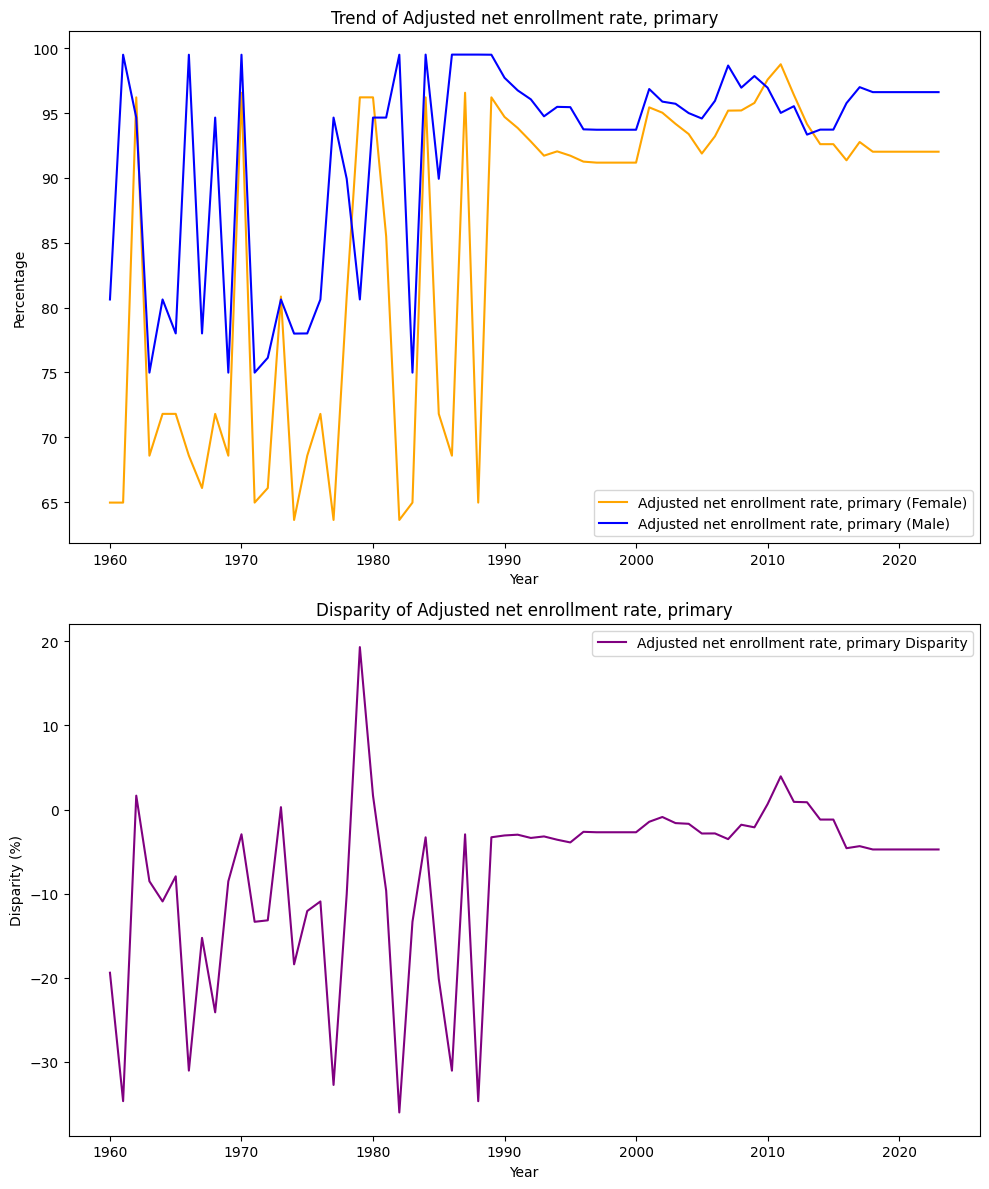

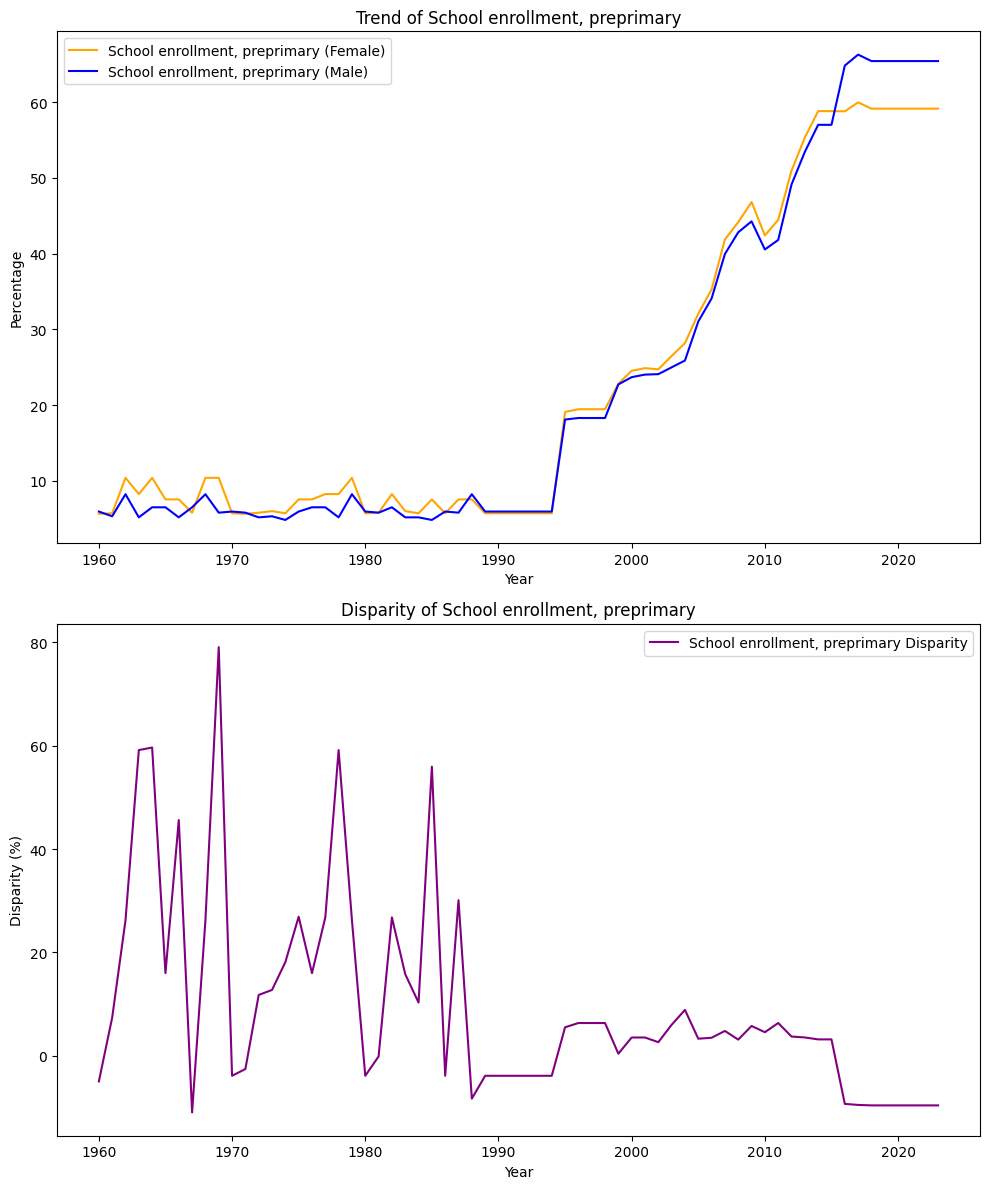

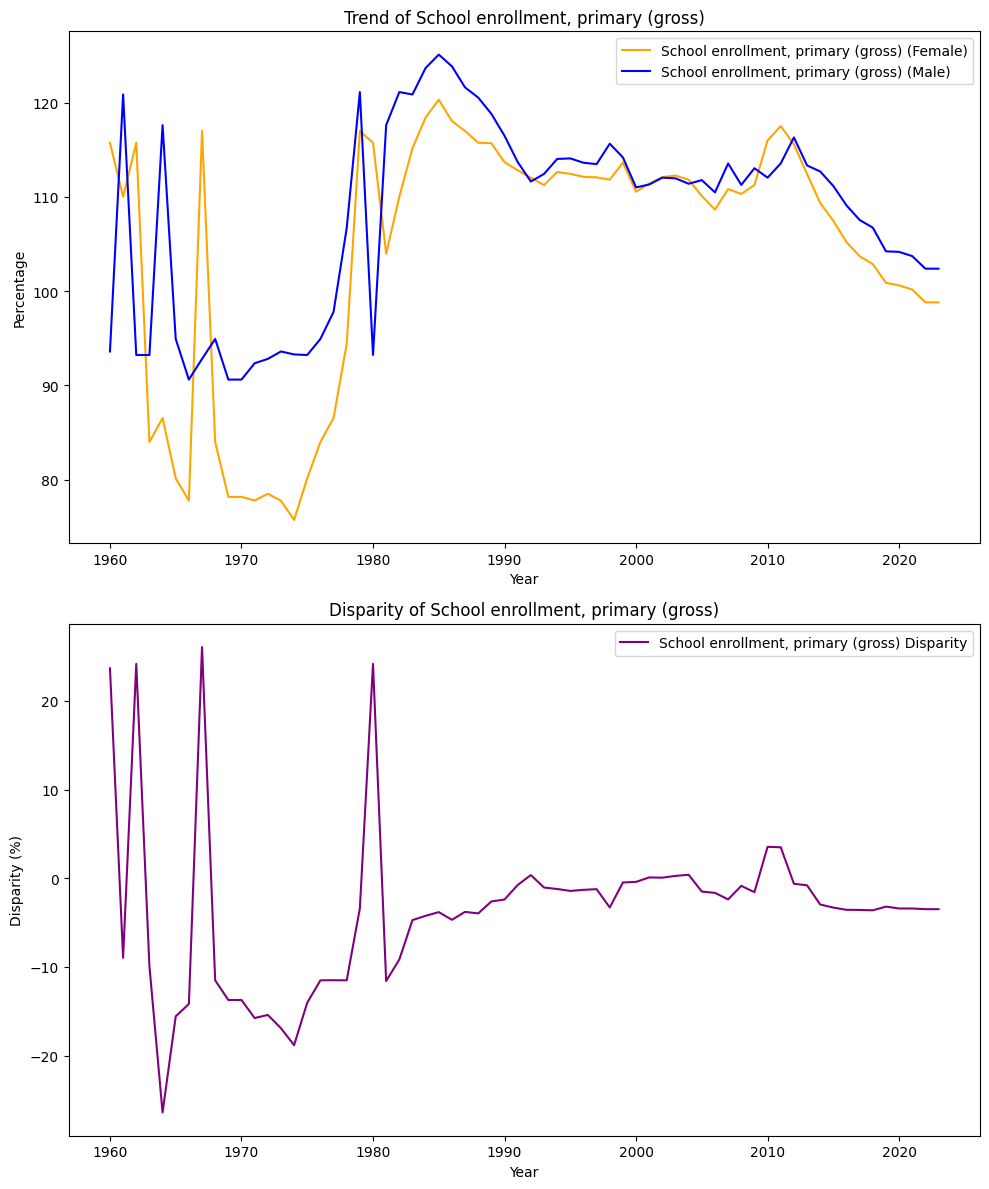

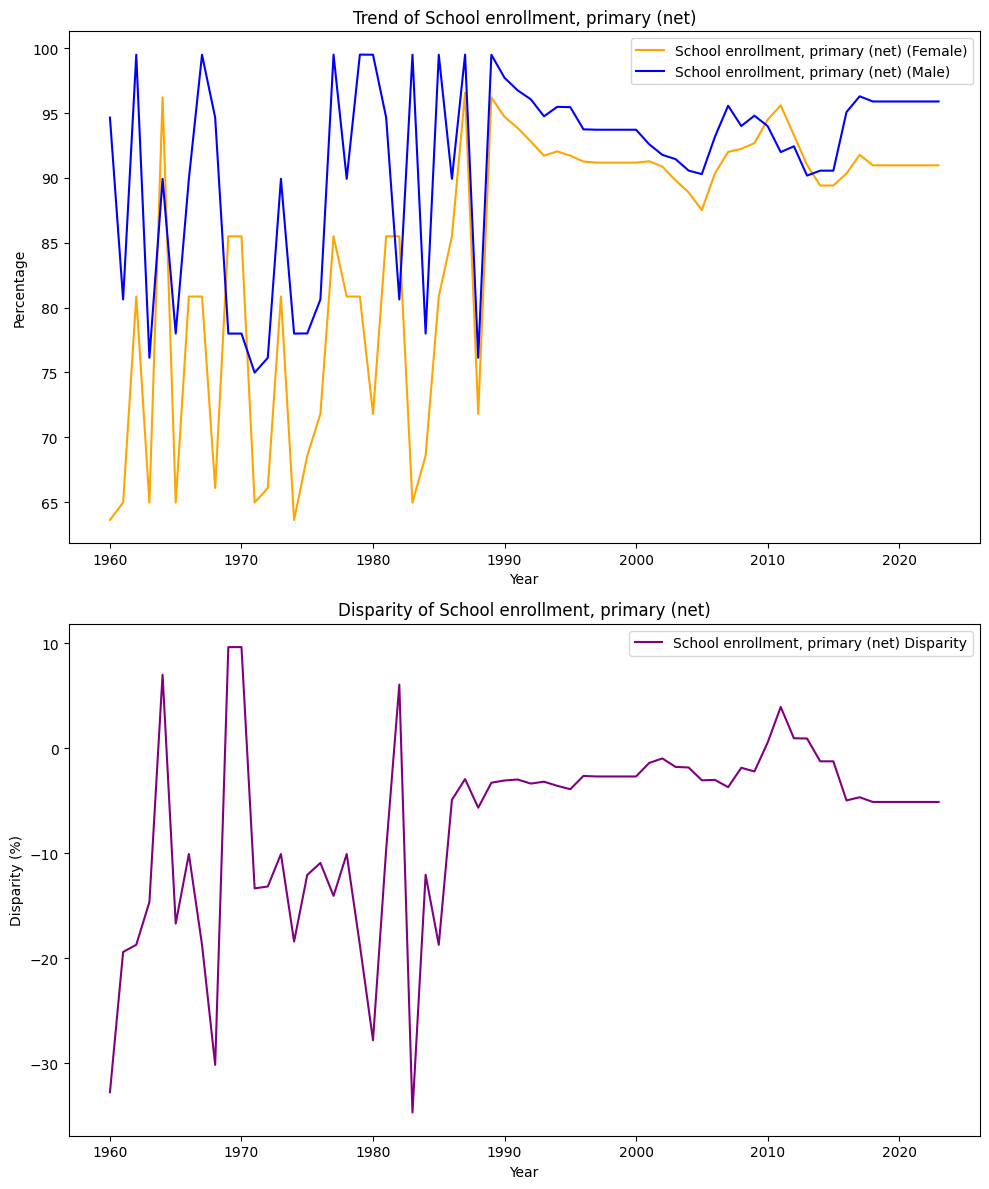

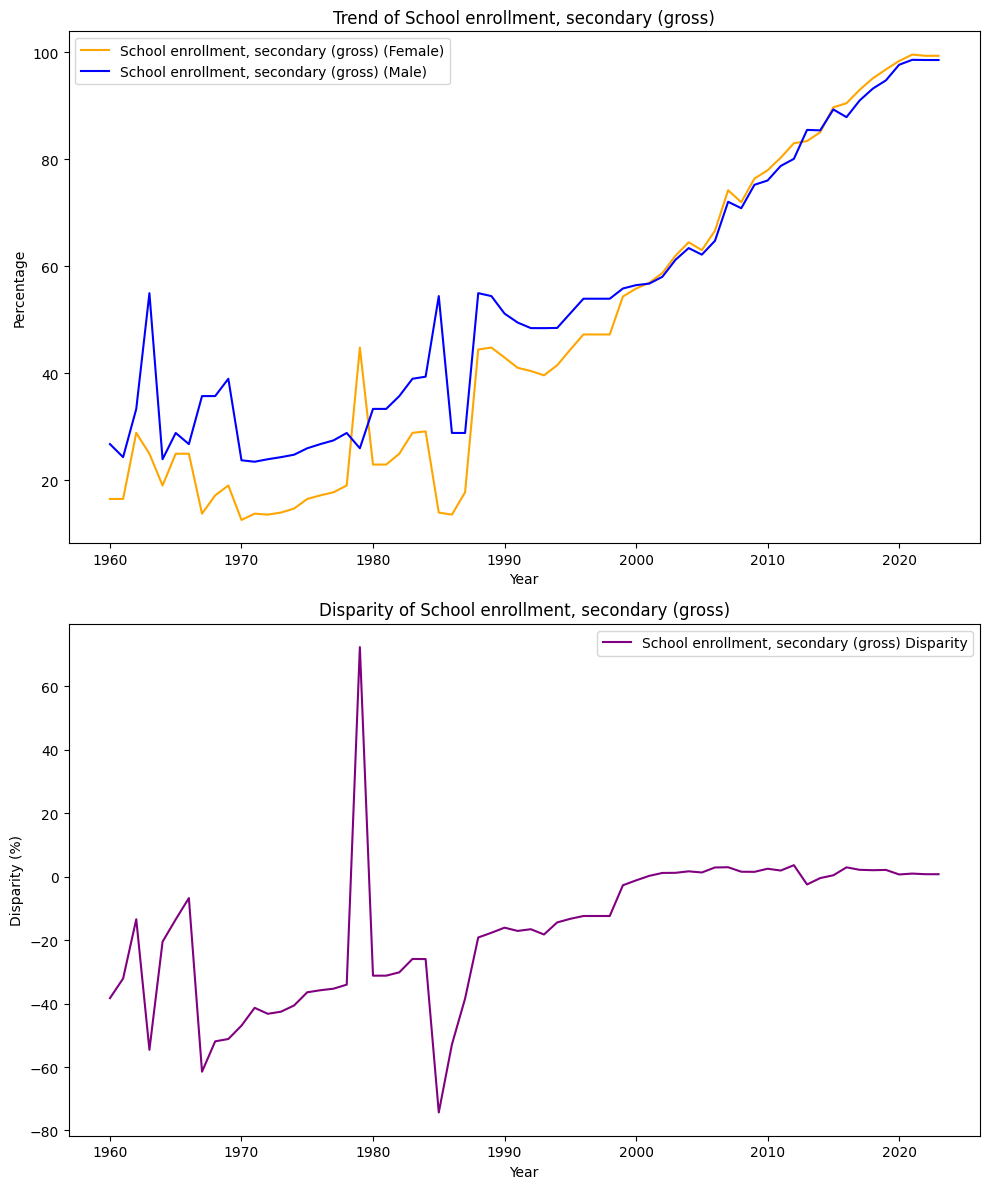

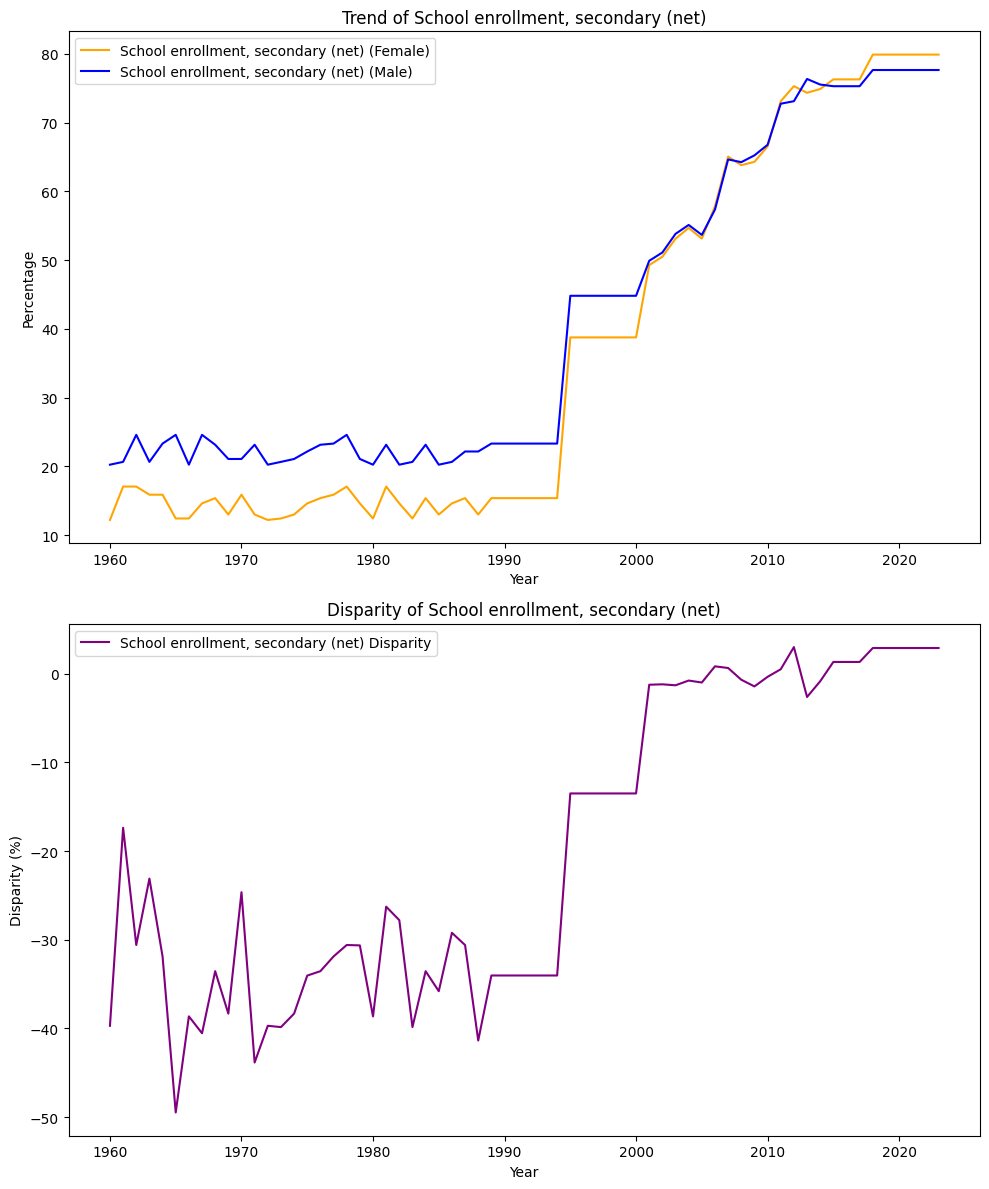

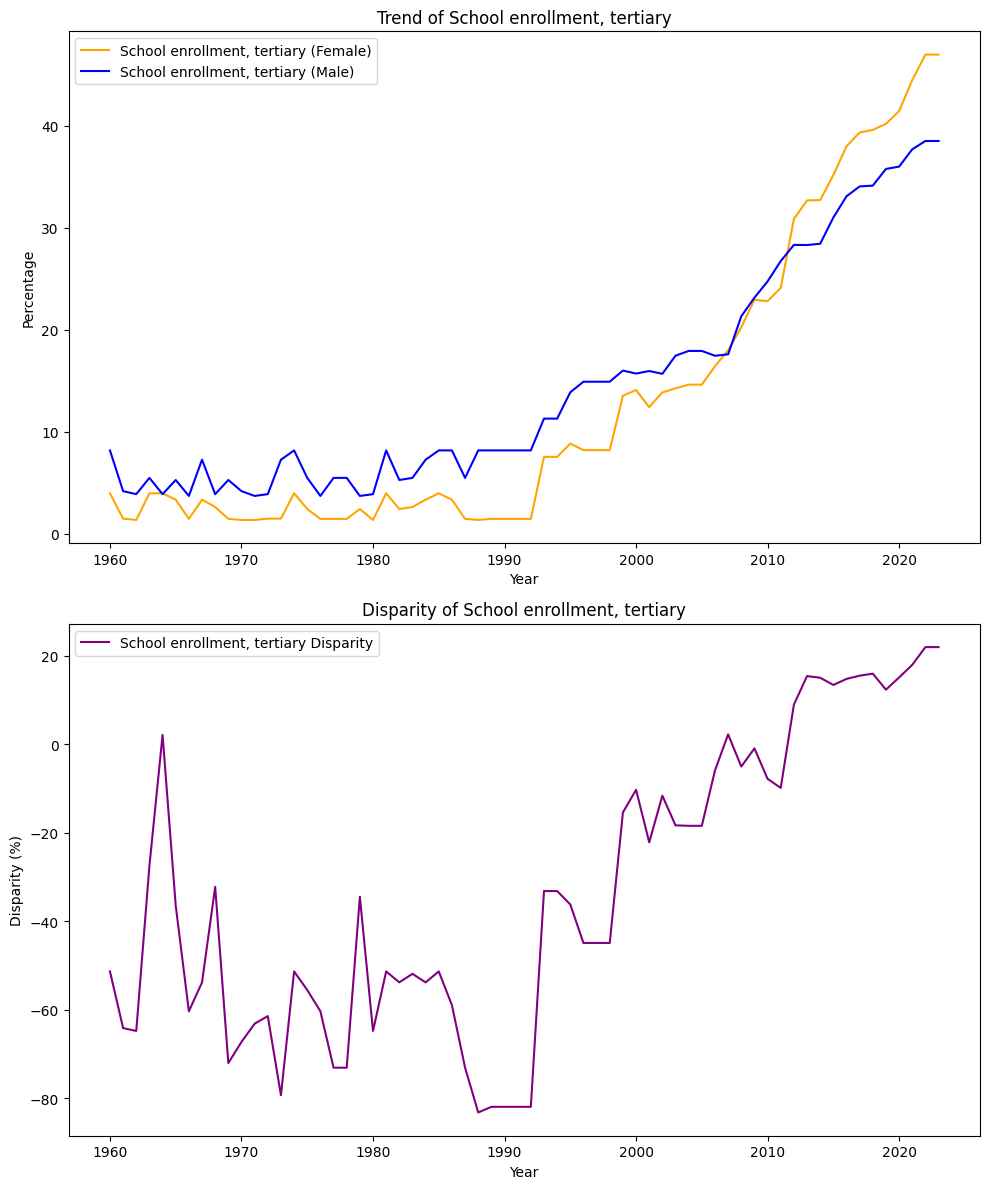

In [19]:
for key, value in indicators.items():
    if len(value) == 2:
        # Plot trend dan disparity index untuk setiap pasangan indikator
        fig, axes = plt.subplots(2, 1, figsize=(10, 12))

        # Trend Plot
        sns.lineplot(ax=axes[0], data=data_clean, x='Year', y=value[0], label=f'{key} (Female)', color='orange')
        sns.lineplot(ax=axes[0], data=data_clean, x='Year', y=value[1], label=f'{key} (Male)', color='blue')
        axes[0].set_title(f'Trend of {key}')
        axes[0].set_xlabel('Year')
        axes[0].set_ylabel('Percentage')
        axes[0].legend()

        # Disparity Index Plot
        disparity_col = f'{key} Disparity'
        sns.lineplot(ax=axes[1], data=data_clean, x='Year', y=disparity_col, label=disparity_col, color='purple')
        axes[1].set_title(f'Disparity of {key}')
        axes[1].set_xlabel('Year')
        axes[1].set_ylabel('Disparity (%)')
        axes[1].legend()

        # Tampilkan plot
        plt.tight_layout()
        plt.show()


### Korelasi antarfitur (dengan *Correlation Heatmap*)

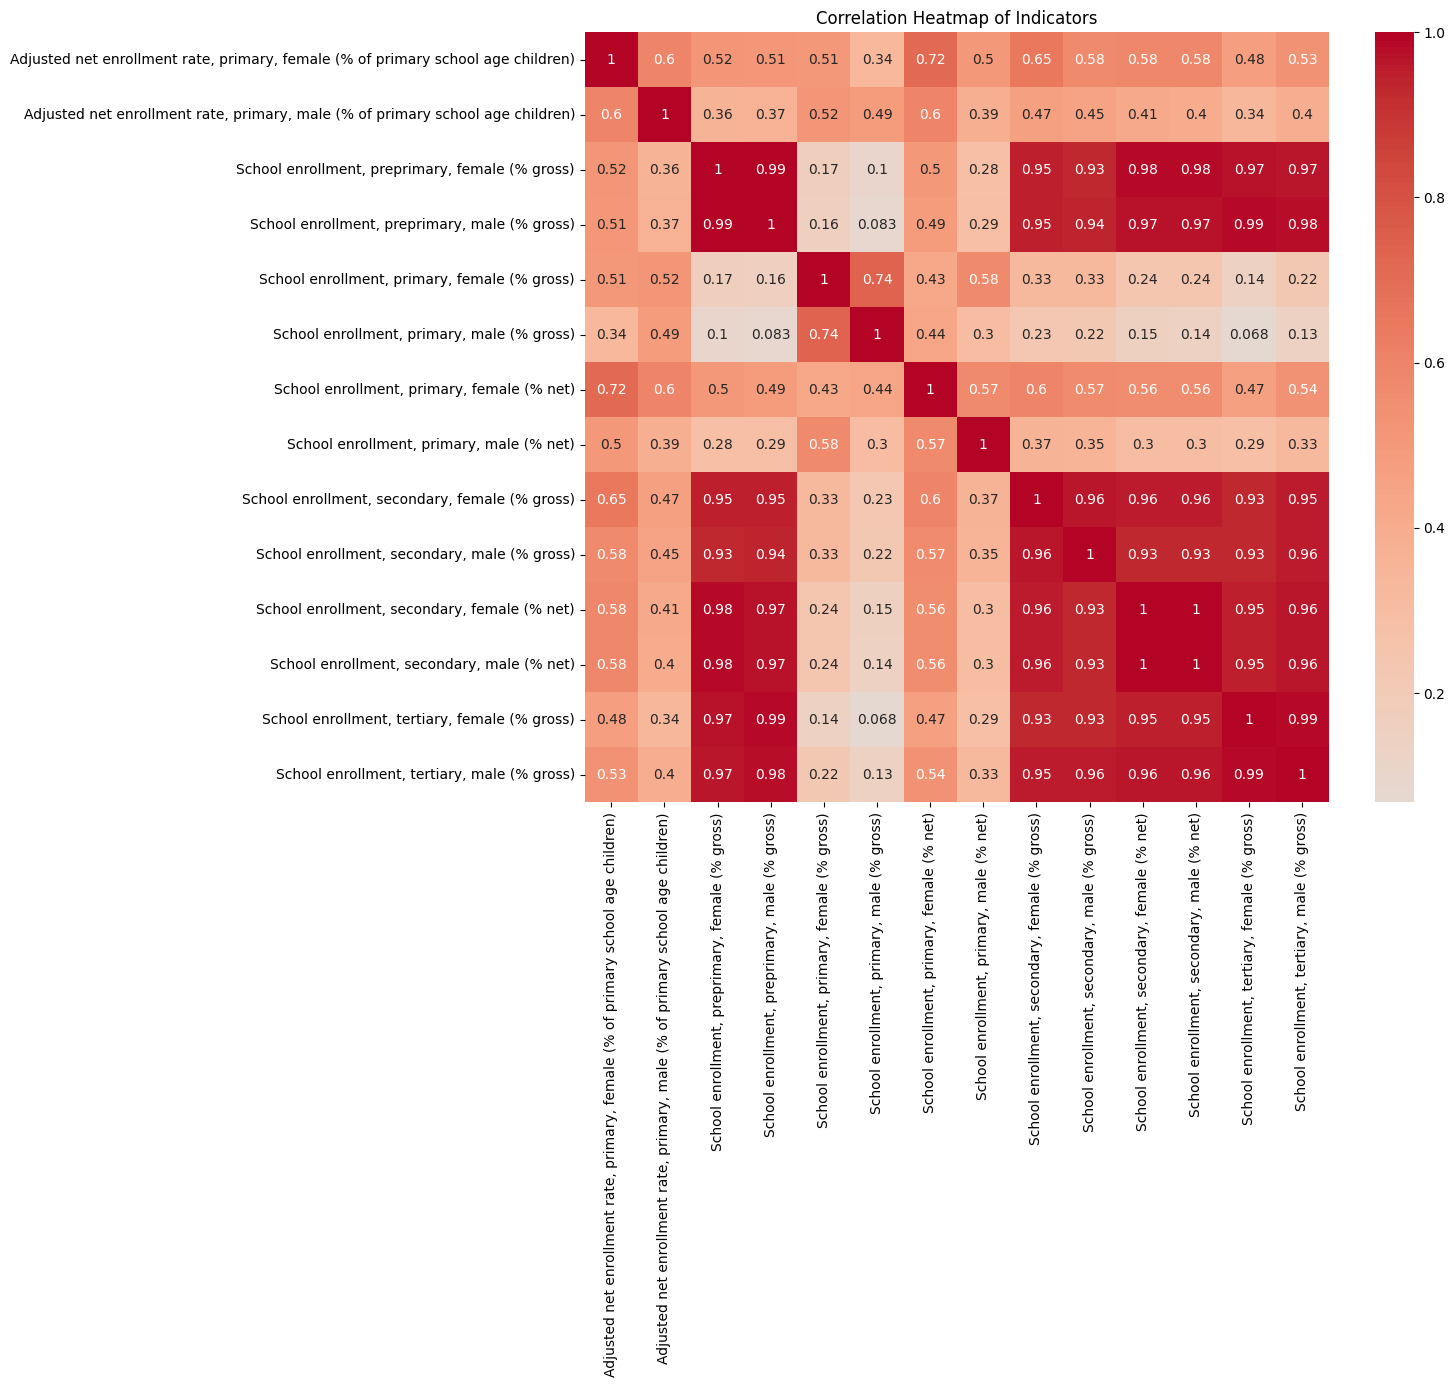

In [20]:
# Plot trend dan disparity index untuk setiap set indikator dengan beberapa pasangan
correlation_matrix = data_clean[[indicator for sublist in indicators.values() for indicator in sublist]].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Indicators')
plt.show()

### Rangkuman statistik dataset

In [21]:
# Statistik deskriptif dari data_clean
summary_stats = data_clean[[indicator for sublist in indicators.values() for indicator in sublist]].describe().transpose()
print(summary_stats)

                                                    count        mean  \
Adjusted net enrollment rate, primary, female (...   64.0   85.024958   
Adjusted net enrollment rate, primary, male (% ...   64.0   92.072612   
School enrollment, preprimary, female (% gross)      64.0   22.828762   
School enrollment, preprimary, male (% gross)        64.0   22.584105   
School enrollment, primary, female (% gross)         64.0  104.259746   
School enrollment, primary, male (% gross)           64.0  108.156255   
School enrollment, primary, female (% net)           64.0   84.599220   
School enrollment, primary, male (% net)             64.0   91.213605   
School enrollment, secondary, female (% gross)       64.0   47.224478   
School enrollment, secondary, male (% gross)         64.0   53.120861   
School enrollment, secondary, female (% net)         64.0   36.354116   
School enrollment, secondary, male (% net)           64.0   40.878803   
School enrollment, tertiary, female (% gross)      

## **Prediction Model**

### Setup Dataset untuk Modelling

In [22]:
# Load the cleaned dataset dengan disparity index
file_path_disparity = 'Gender_Disparity_Index_IDN.csv'
data_disparity = pd.read_csv(file_path_disparity)

# Load the original normalized dataset
file_path_original = 'Gender_Disparity_Index_IDN_Filled.csv'
data_original = pd.read_csv(file_path_original)

# Bersihkan nama kolom dalam dataset asli
data_original.columns = data_original.columns.str.strip()

# Definisikan features (X) berdasarkan kolom dalam dataset asli
features = [
    'Adjusted net enrollment rate, primary, female (% of primary school age children)',
    'Adjusted net enrollment rate, primary, male (% of primary school age children)',
    'School enrollment, preprimary, female (% gross)',
    'School enrollment, preprimary, male (% gross)',
    'School enrollment, primary, female (% gross)',
    'School enrollment, primary, female (% net)',
    'School enrollment, primary, male (% gross)',
    'School enrollment, primary, male (% net)',
    'School enrollment, secondary, female (% gross)',
    'School enrollment, secondary, female (% net)',
    'School enrollment, secondary, male (% gross)',
    'School enrollment, secondary, male (% net)',
    'School enrollment, tertiary, female (% gross)',
    'School enrollment, tertiary, male (% gross)'
]

# Definisikan targets (disparity indices) berdasarkan kolom dalam dataset disparity
targets = [
    'Adjusted net enrollment rate, primary Disparity',
    'School enrollment, preprimary Disparity',
    'School enrollment, primary (gross) Disparity',
    'School enrollment, primary (net) Disparity',
    'School enrollment, secondary (gross) Disparity',
    'School enrollment, secondary (net) Disparity',
    'School enrollment, tertiary Disparity'
]

# Verifikasi bahwa semua features ada dalam dataset
missing_features = [feature for feature in features if feature not in data_original.columns]
if missing_features:
    print(f"Missing features in the dataset: {missing_features}")
else:
    print("All features are present.")

# Bagi data menjadi training (1960-2010) dan testing sets (2011-2022)
train_data = data_original[data_original['Year'] <= 2010]
test_data = data_original[data_original['Year'] > 2010]

# Indeks disparity yang sesuai
train_disparity = data_disparity[data_disparity['Year'] <= 2010]
test_disparity = data_disparity[data_disparity['Year'] > 2010]


All features are present.


### Random Forest

Model for Adjusted net enrollment rate, primary Disparity:
  Mean Squared Error: 5.648692266250378
  R-squared: 0.3074476786955591



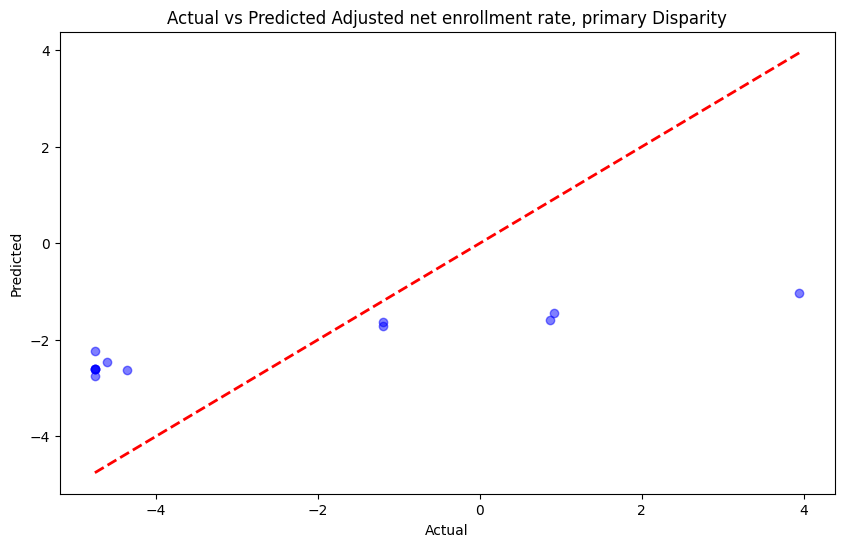

Model for School enrollment, preprimary Disparity:
  Mean Squared Error: 111.94290481106113
  R-squared: -1.5446251936565418



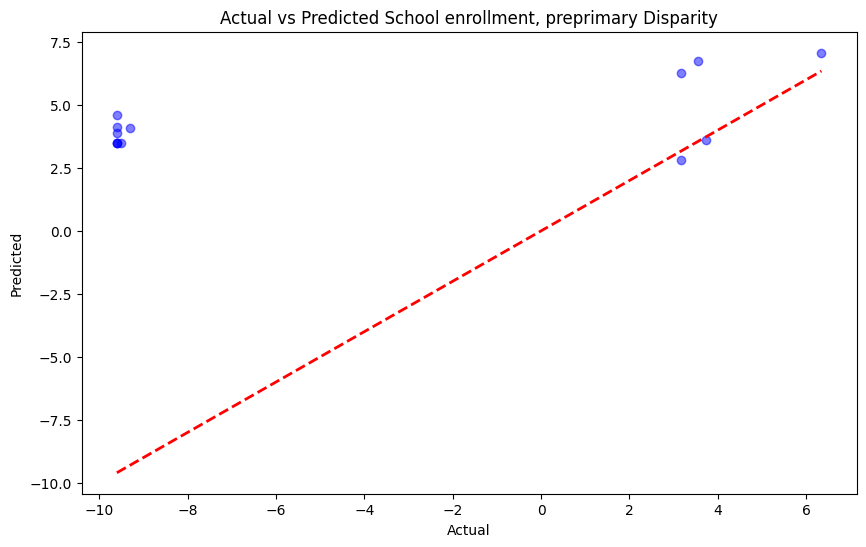

Model for School enrollment, primary (gross) Disparity:
  Mean Squared Error: 21.895042279706573
  R-squared: -4.602731637871804



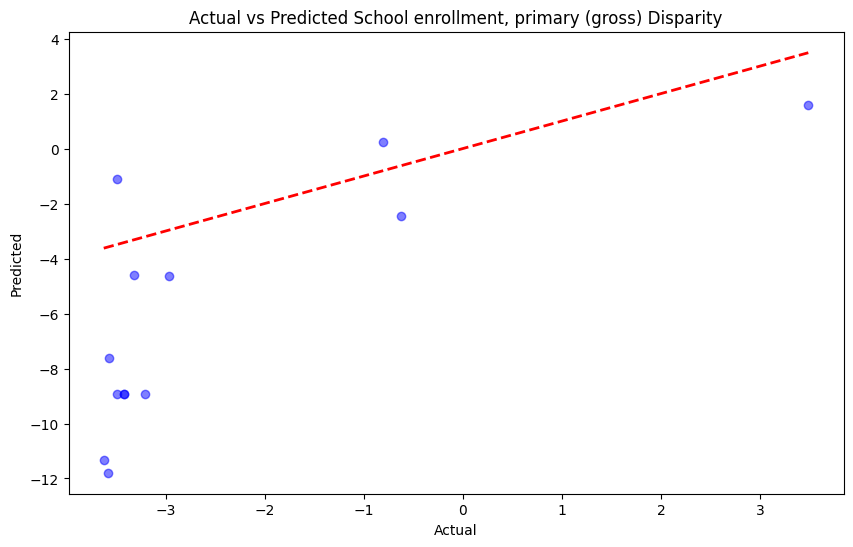

Model for School enrollment, primary (net) Disparity:
  Mean Squared Error: 3.3376686457679776
  R-squared: 0.6334256935696816



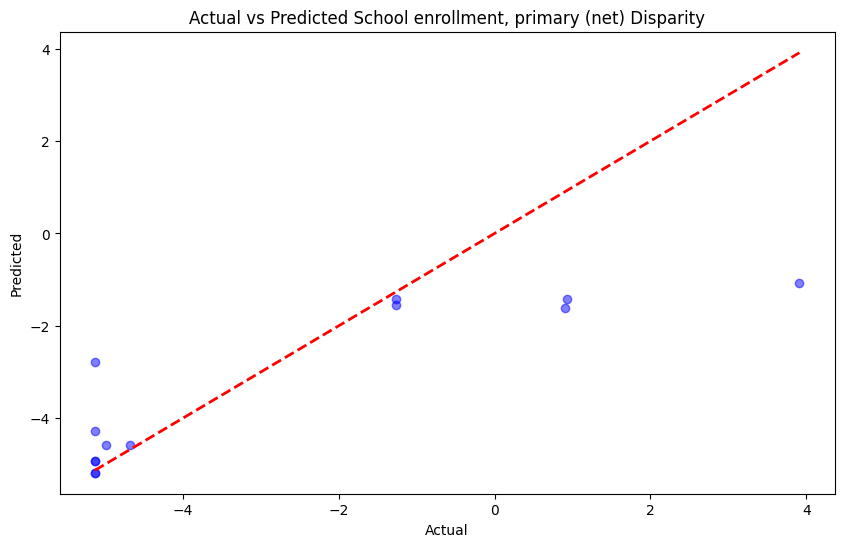

Model for School enrollment, secondary (gross) Disparity:
  Mean Squared Error: 34.64750792615146
  R-squared: -14.389083170757056



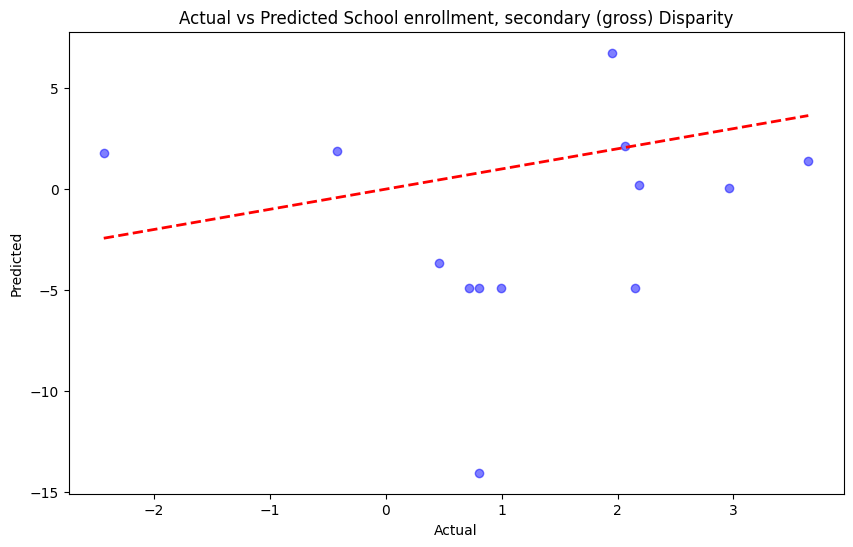

Model for School enrollment, secondary (net) Disparity:
  Mean Squared Error: 142.45322712638196
  R-squared: -48.67133440057517



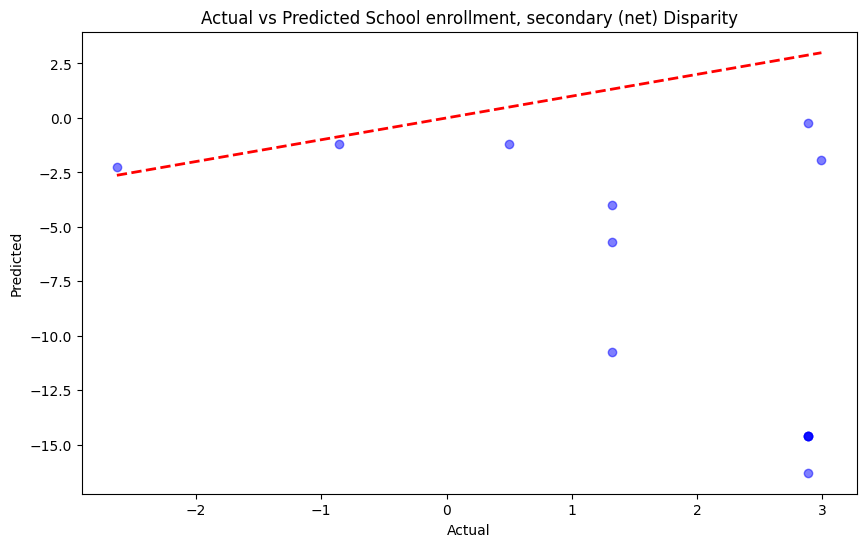

Model for School enrollment, tertiary Disparity:
  Mean Squared Error: 1506.3770044381065
  R-squared: -25.06962714473063



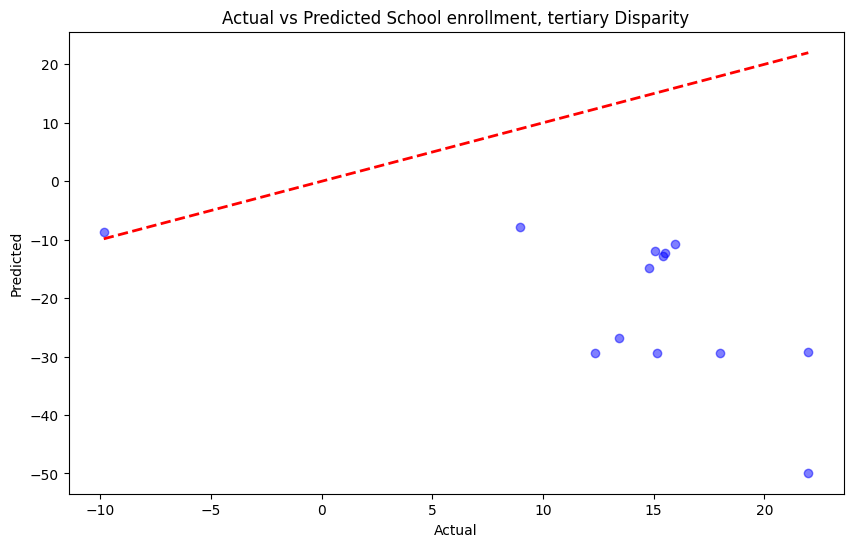

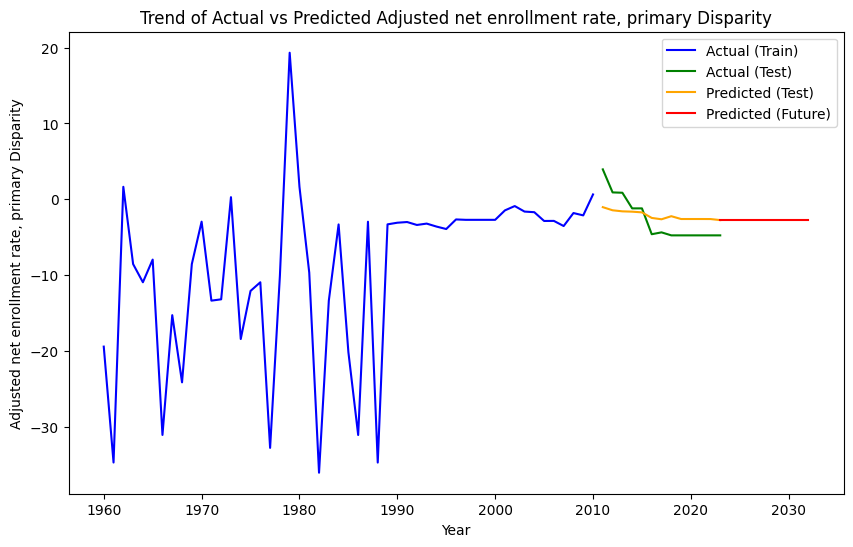

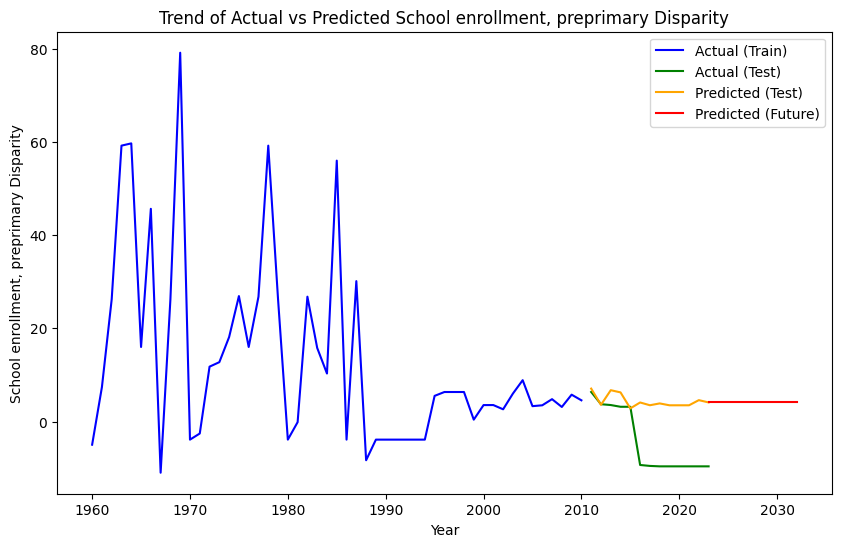

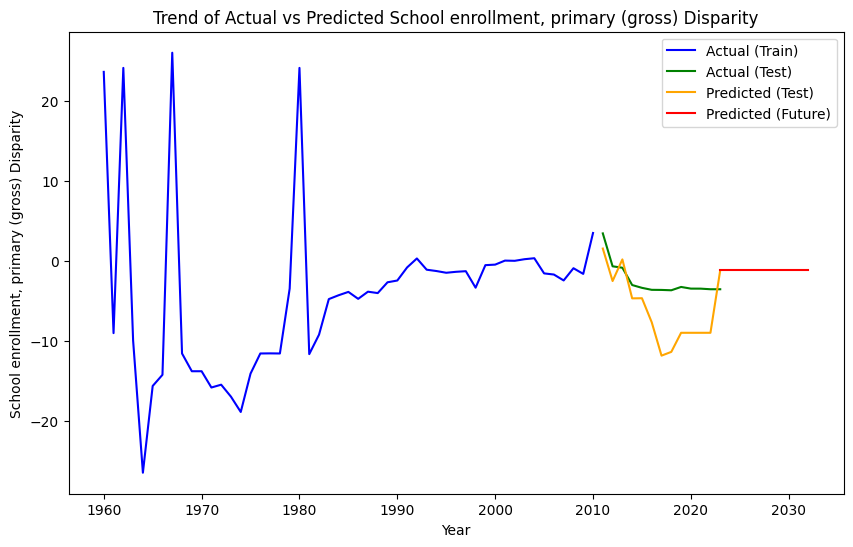

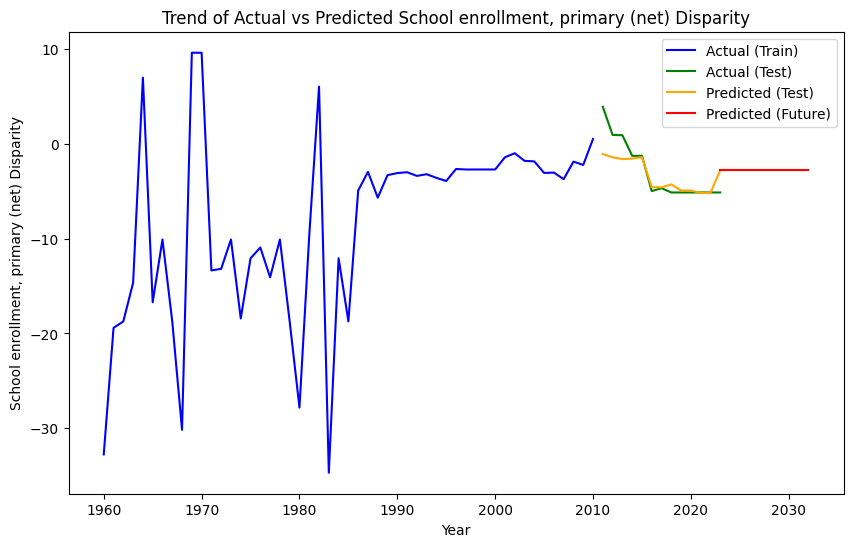

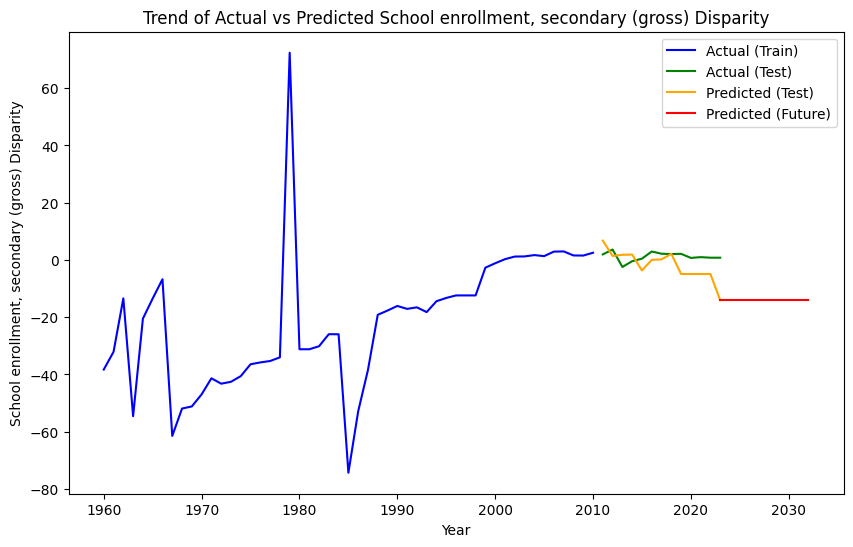

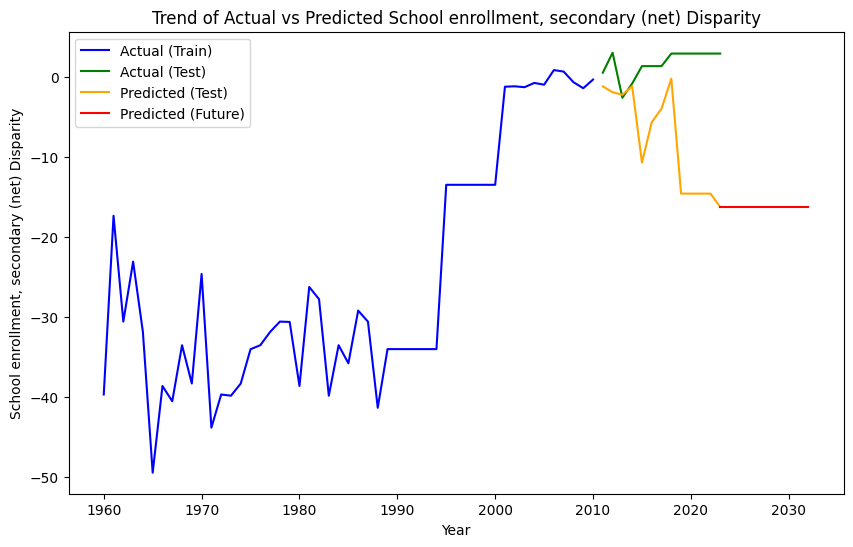

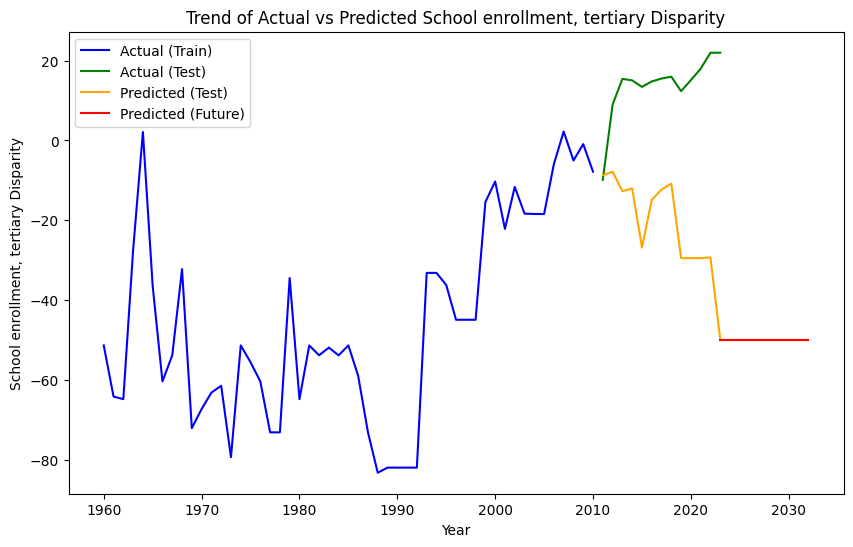

In [23]:
# Buat model Random Forest untuk setiap target (disparity index)
models = {}
predictions = {}
for target in targets:
    # Siapkan features dan target
    X_train = train_data[features]
    y_train = train_disparity[target]
    X_test = test_data[features]
    y_test = test_disparity[target]

    # Latih model Random Forest regression
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    models[target] = model

    # Lakukan prediksi pada test set
    y_pred = model.predict(X_test)
    predictions[target] = y_pred

    # Evaluasi model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Model for {target}:')
    print(f'  Mean Squared Error: {mse}')
    print(f'  R-squared: {r2}')
    print()

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted {target}')
    plt.show()

# Memprediksi disparity di masa depan menggunakan pendekatan rolling window
# Tahun di masa depan
future_years = np.arange(2023, 2033)

# Lakukan prediksi untuk tahun di masa depan
future_predictions = {}
for target in targets:
    model = models[target]
    current_year = test_data['Year'].max()
    X_future = test_data[features].iloc[-1].copy().to_frame().T
    future_pred = []
    
    for year in future_years:
        # Prediksi disparity untuk tahun berikutnya
        pred = model.predict(X_future)[0]
        future_pred.append(pred)
        
        # Update features untuk prediksi berikutnya (gunakan pendekatan sederhana di sini)
        for feature in features:
            X_future[feature] = X_future[feature].values[0]  # Gunakan nilai terakhir yang diketahui untuk kesederhanaan
    
    future_predictions[target] = future_pred

# Visualisasikan tren prediksi vs actual disparity index dari waktu ke waktu
for target in targets:
    plt.figure(figsize=(10, 6))
    plt.plot(train_disparity['Year'], train_disparity[target], label='Actual (Train)', color='blue')
    plt.plot(test_disparity['Year'], test_disparity[target], label='Actual (Test)', color='green')
    plt.plot(test_disparity['Year'], predictions[target], label='Predicted (Test)', color='orange')
    plt.plot(future_years, future_predictions[target], label='Predicted (Future)', color='red')
    plt.xlabel('Year')
    plt.ylabel(target)
    plt.title(f'Trend of Actual vs Predicted {target}')
    plt.legend()
    plt.show()


### Gradient Boosting

All features are present.
Model for Adjusted net enrollment rate, primary Disparity:
  Mean Squared Error: 6.618210691579131
  R-squared: 0.18858083228925626



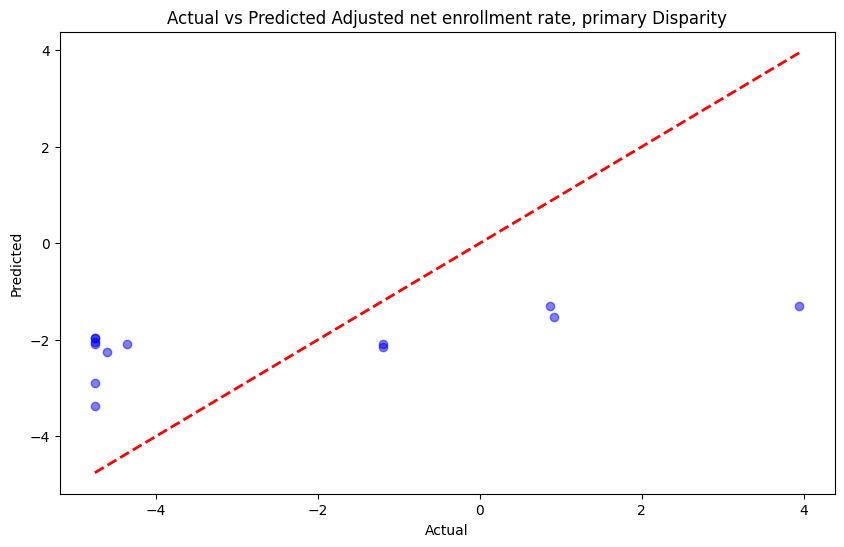

Model for School enrollment, preprimary Disparity:
  Mean Squared Error: 251.68910436960348
  R-squared: -4.721259753163563



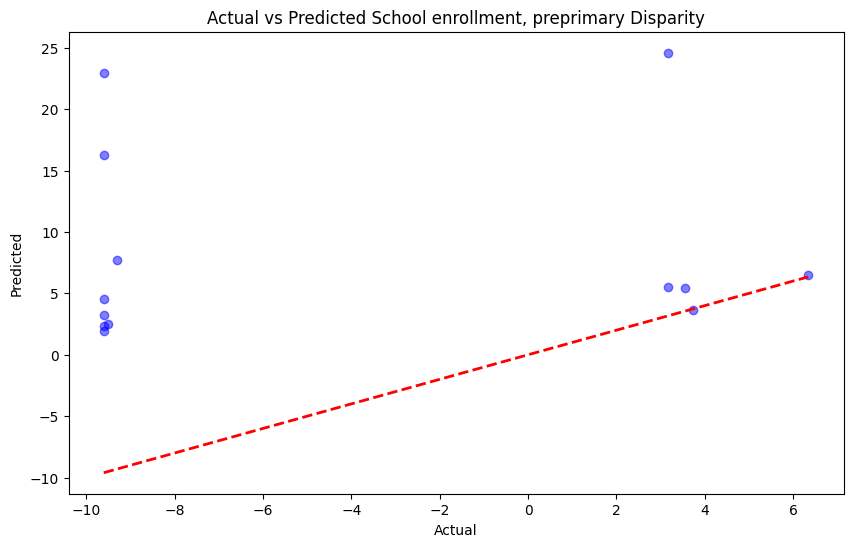

Model for School enrollment, primary (gross) Disparity:
  Mean Squared Error: 14.21009673652773
  R-squared: -2.63622766952838



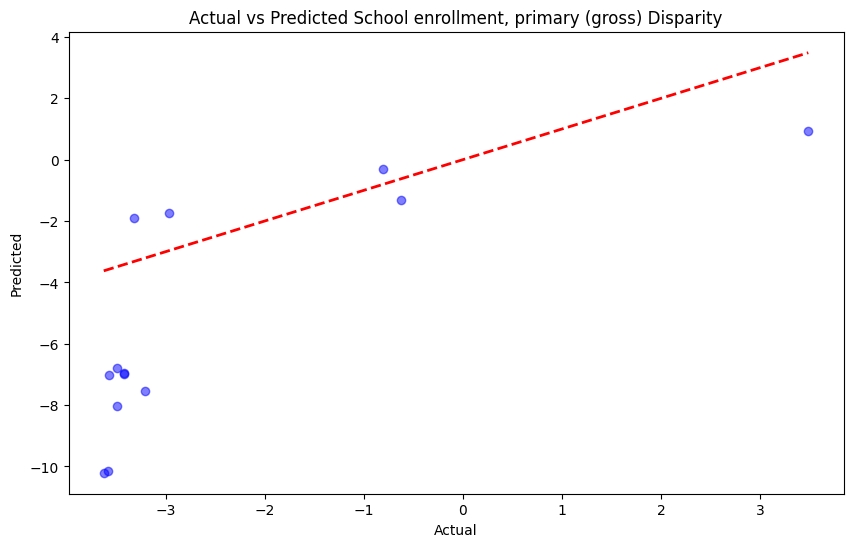

Model for School enrollment, primary (net) Disparity:
  Mean Squared Error: 5.610457613240466
  R-squared: 0.38380653485837557



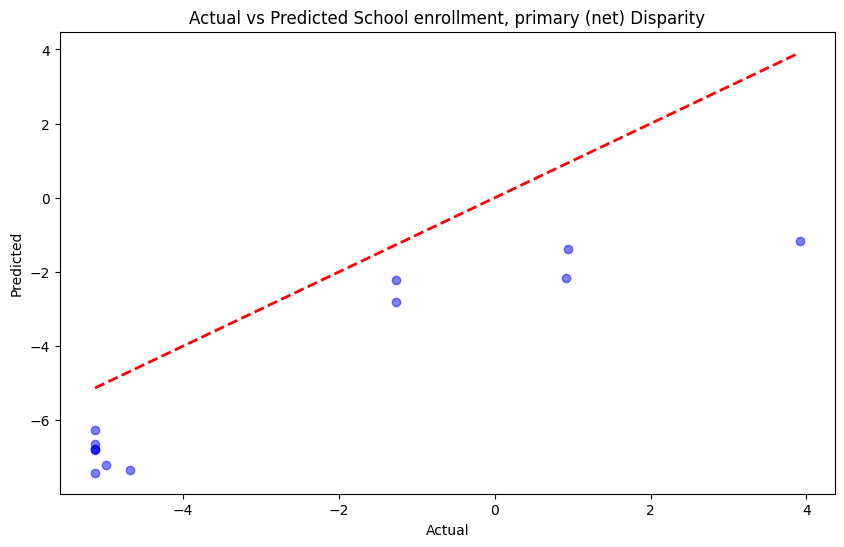

Model for School enrollment, secondary (gross) Disparity:
  Mean Squared Error: 23.82701790685394
  R-squared: -9.58303994218675



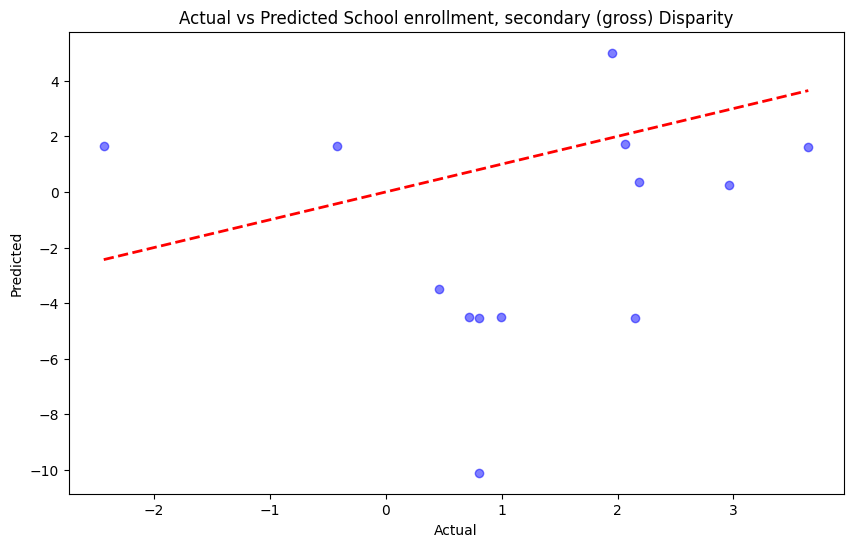

Model for School enrollment, secondary (net) Disparity:
  Mean Squared Error: 107.56160542426935
  R-squared: -36.50514171891402



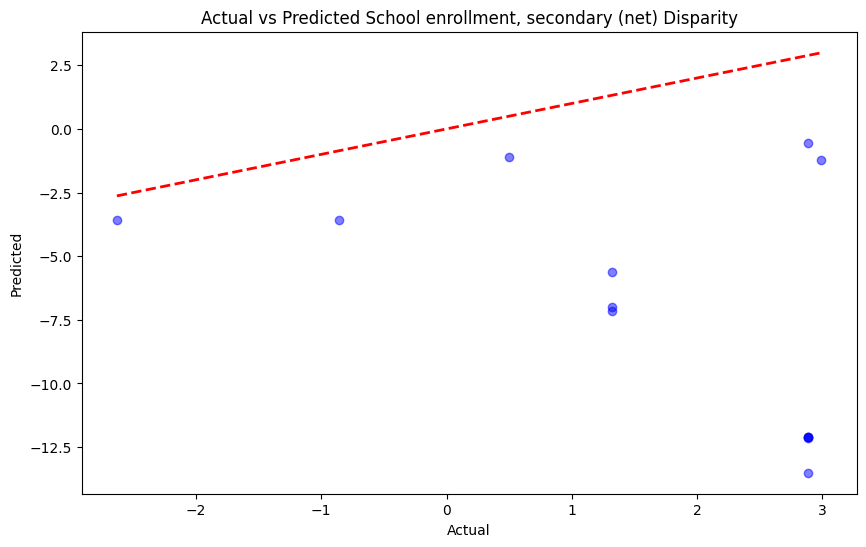

Model for School enrollment, tertiary Disparity:
  Mean Squared Error: 1271.9623049837055
  R-squared: -21.01280485255828



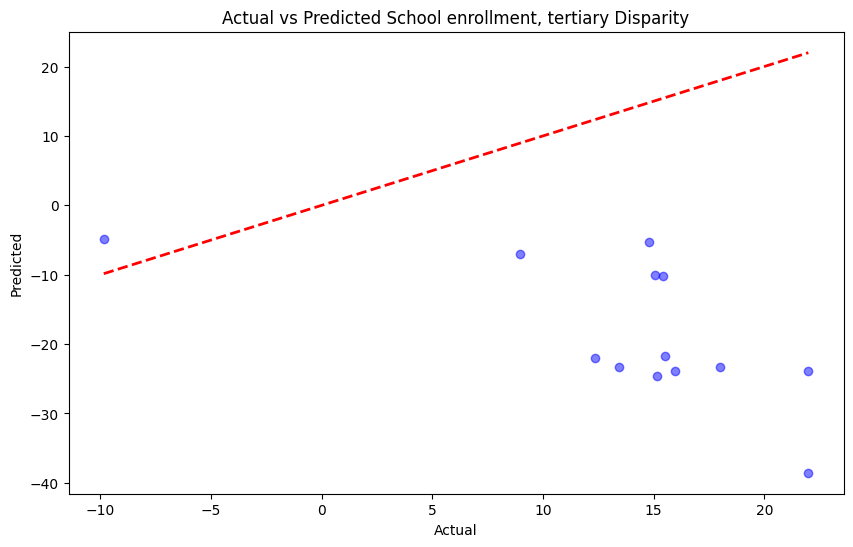

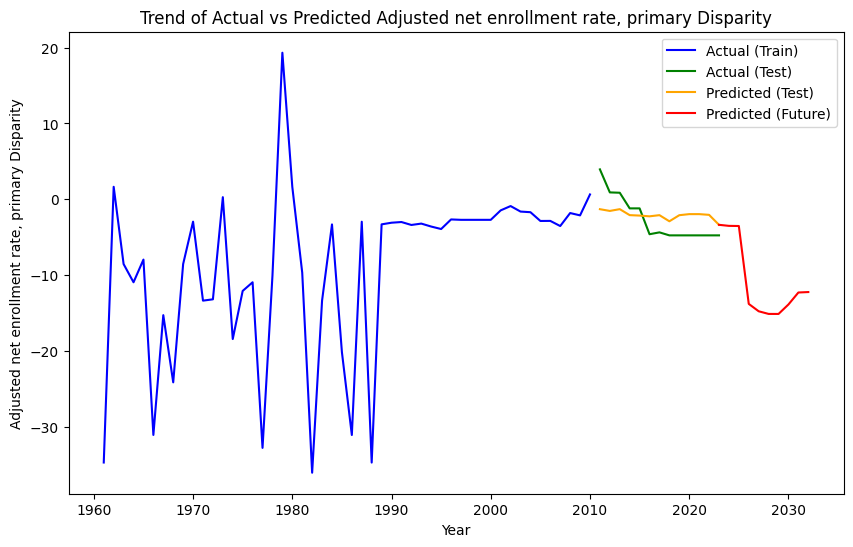

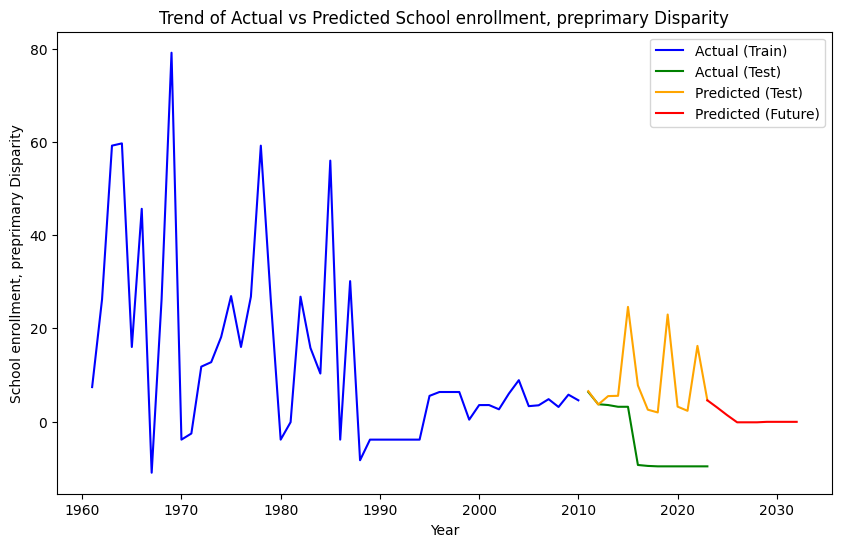

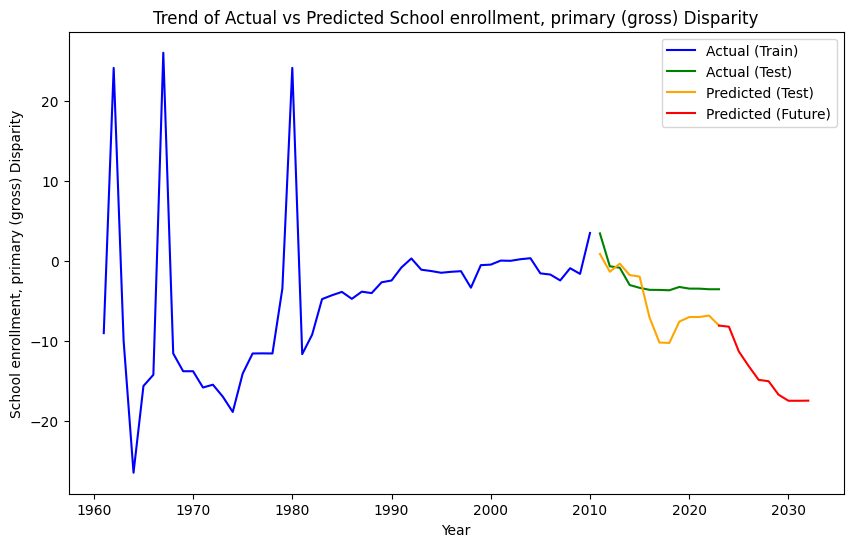

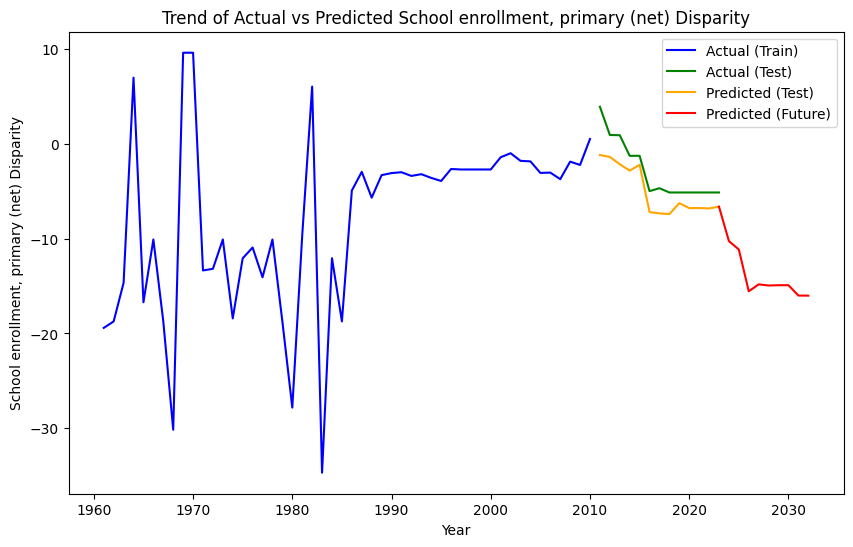

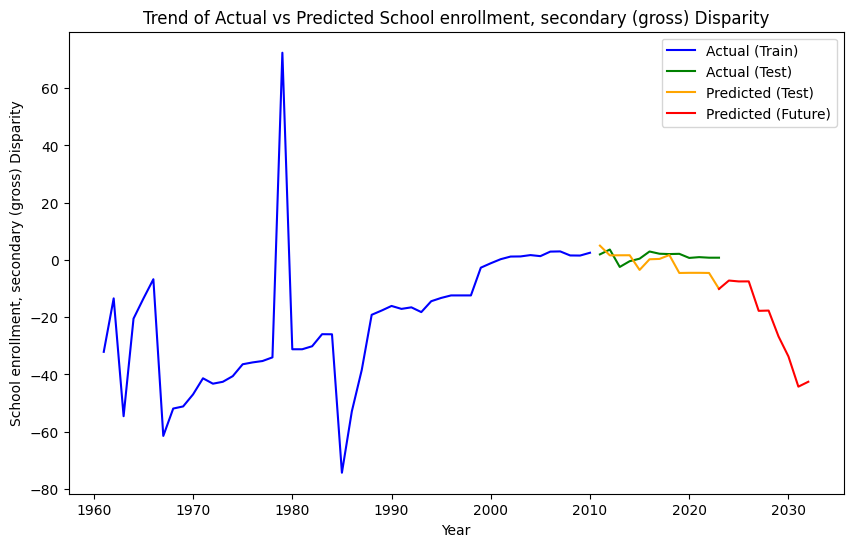

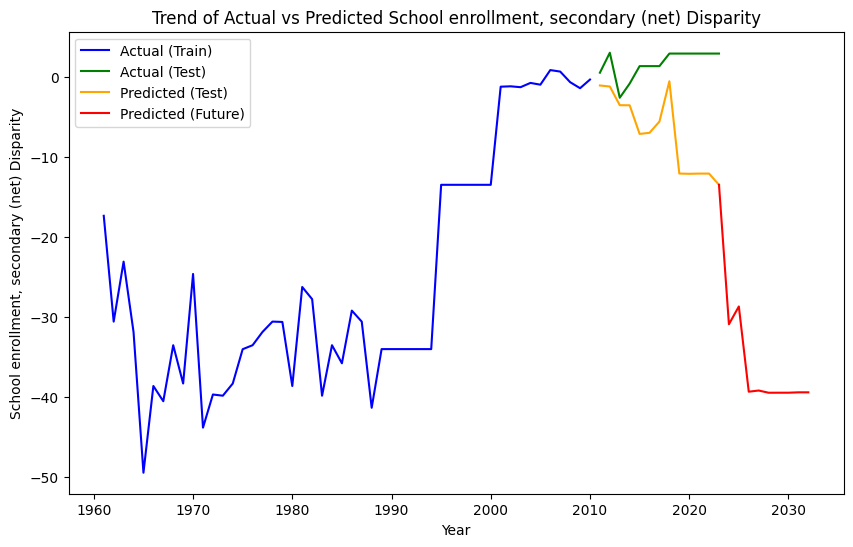

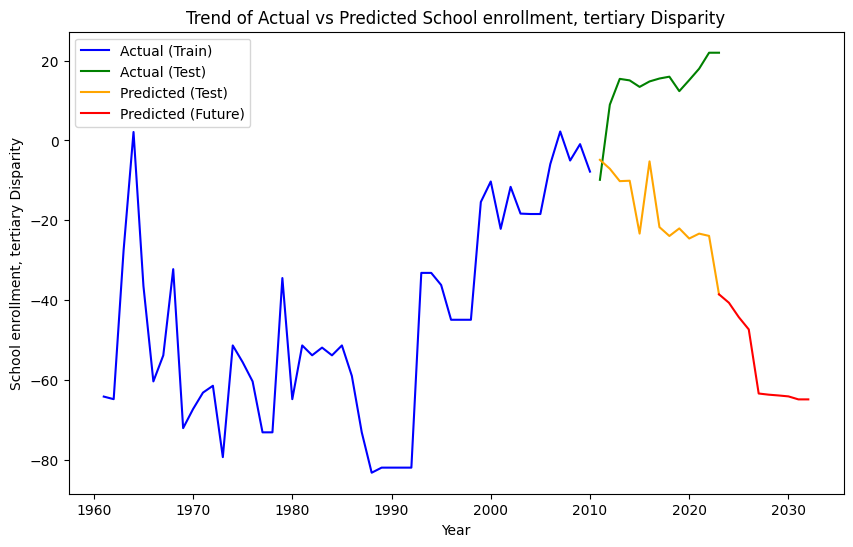

In [24]:
file_path_disparity = 'Gender_Disparity_Index_IDN.csv'
data_disparity = pd.read_csv(file_path_disparity)

file_path_original = 'Gender_Disparity_Index_IDN_Filled.csv'
data_original = pd.read_csv(file_path_original)

# Bersihkan nama kolom dalam original dataset
data_original.columns = data_original.columns.str.strip()

# Tentukan features (X) berdasarkan kolom dalam original dataset
features = [
    'Adjusted net enrollment rate, primary, female (% of primary school age children)',
    'Adjusted net enrollment rate, primary, male (% of primary school age children)',
    'School enrollment, preprimary, female (% gross)',
    'School enrollment, preprimary, male (% gross)',
    'School enrollment, primary, female (% gross)',
    'School enrollment, primary, female (% net)',
    'School enrollment, primary, male (% gross)',
    'School enrollment, primary, male (% net)',
    'School enrollment, secondary, female (% gross)',
    'School enrollment, secondary, female (% net)',
    'School enrollment, secondary, male (% gross)',
    'School enrollment, secondary, male (% net)',
    'School enrollment, tertiary, female (% gross)',
    'School enrollment, tertiary, male (% gross)'
]

# Tentukan targets (disparity indices) berdasarkan kolom dalam disparity dataset
targets = [
    'Adjusted net enrollment rate, primary Disparity',
    'School enrollment, preprimary Disparity',
    'School enrollment, primary (gross) Disparity',
    'School enrollment, primary (net) Disparity',
    'School enrollment, secondary (gross) Disparity',
    'School enrollment, secondary (net) Disparity',
    'School enrollment, tertiary Disparity'
]

# Impute nilai yang hilang dalam original dataset
imputer = SimpleImputer(strategy='mean')
data_original_imputed = pd.DataFrame(imputer.fit_transform(data_original), columns=data_original.columns)

# Verifikasi bahwa semua features ada dalam dataset
missing_features = [feature for feature in features if feature not in data_original_imputed.columns]
if missing_features:
    print(f"Missing features in the dataset: {missing_features}")
else:
    print("All features are present.")

# Feature Engineering: Tambahkan perubahan year-over-year sebagai features
for feature in features:
    data_original_imputed[f'{feature} YoY Change'] = data_original_imputed[feature].pct_change()

# Hapus baris pertama karena nilai NaN dalam YoY change features
data_original_imputed = data_original_imputed.dropna().reset_index(drop=True)

# Sinkronkan index disparity dataset dengan original dataset
data_disparity = data_disparity[data_disparity['Year'].isin(data_original_imputed['Year'])].reset_index(drop=True)

# Pisahkan data menjadi training (1960-2010) dan testing sets (2011-2022)
train_data = data_original_imputed[data_original_imputed['Year'] <= 2010]
test_data = data_original_imputed[data_original_imputed['Year'] > 2010]

# Disparity set yang sesuai
train_disparity = data_disparity[data_disparity['Year'] <= 2010]
test_disparity = data_disparity[data_disparity['Year'] > 2010]

# Buat model Gradient Boosting untuk setiap target (disparity index)
models = {}
predictions = {}

# Hyperparameter tuning untuk Gradient Boosting
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

for target in targets:
    # Siapkan features dan target
    X_train = train_data.drop(columns=['Year'])
    y_train = train_disparity[target]
    X_test = test_data.drop(columns=['Year'])
    y_test = test_disparity[target]

    # Hyperparameter tuning
    gb_model = GradientBoostingRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    models[target] = best_model

    # Lakukan prediksi pada test set
    y_pred = best_model.predict(X_test)
    predictions[target] = y_pred

    # Evaluasi model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Model for {target}:')
    print(f'  Mean Squared Error: {mse}')
    print(f'  R-squared: {r2}')
    print()

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted {target}')
    plt.show()

# Memprediksi disparity di masa depan menggunakan pendekatan rolling window

# Generate tahun di masa depan
future_years = np.arange(2023, 2033)

# Lakukan prediksi untuk tahun di masa depan
future_predictions = {}
for target in targets:
    model = models[target]
    current_year = test_data['Year'].max()
    X_future = test_data.drop(columns=['Year']).iloc[-1].copy().to_frame().T
    future_pred = []
    
    for year in future_years:
        # Prediksi disparity untuk tahun berikutnya
        pred = model.predict(X_future)[0]
        future_pred.append(pred)
        
        for feature in X_future.columns:
            X_future[feature] = X_future[feature].values[0] * (1 + pred / 100)   
             
    future_predictions[target] = future_pred

# Visualisasikan tren prediksi vs actual disparity index dari waktu ke waktu
for target in targets:
    plt.figure(figsize=(10, 6))
    plt.plot(train_disparity['Year'], train_disparity[target], label='Actual (Train)', color='blue')
    plt.plot(test_disparity['Year'], test_disparity[target], label='Actual (Test)', color='green')
    plt.plot(test_disparity['Year'], predictions[target], label='Predicted (Test)', color='orange')
    plt.plot(future_years, future_predictions[target], label='Predicted (Future)', color='red')
    plt.xlabel('Year')
    plt.ylabel(target)
    plt.title(f'Trend of Actual vs Predicted {target}')
    plt.legend()
    plt.show()